<a href="https://colab.research.google.com/github/Skyreacher-hub/Healthcare-Data-Analysis/blob/main/Another_copy_of_Hospital_Readmission_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LOAD PACKAGES**

In [1]:


!pip -q install pandas numpy seaborn scikit-learn plotly openpyxl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)





**IMPORT DATA**

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data Analysis Projects - Dec 2025/Healthcare analytics/FY_2025_Hospital_Readmissions_Reduction_Program_Hospital Data.xlsx')

In [3]:
print(df.shape)
print(df.dtypes)
print(df.head())

(18510, 12)
Facility Name                         object
Facility ID                            int64
State                                 object
Measure Name                          object
Number of Discharges                 float64
Footnote                             float64
Excess Readmission Ratio             float64
Predicted Readmission Rate           float64
Expected Readmission Rate            float64
Number of Readmissions                object
Start Date                    datetime64[ns]
End Date                      datetime64[ns]
dtype: object
                     Facility Name  Facility ID State            Measure Name  \
0  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL       READM-30-AMI-HRRP   
1  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL      READM-30-CABG-HRRP   
2  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL        READM-30-HF-HRRP   
3  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL  READM-30-HIP-KNEE-HRRP   
4  SOUTHEAST HEALTH MEDICAL C

In [4]:
print("\nUnique Measure Names:", df['Measure Name'].unique())


Unique Measure Names: ['READM-30-AMI-HRRP' 'READM-30-CABG-HRRP' 'READM-30-HF-HRRP'
 'READM-30-HIP-KNEE-HRRP' 'READM-30-PN-HRRP' 'READM-30-COPD-HRRP']


**DATA CLEANING**

In [5]:
# Find the latest End Date in the file
latest_end = df['End Date'].max()
print("Using data with End Date =", latest_end.date())
df = df[df['End Date'] == latest_end].copy()

Using data with End Date = 2023-06-30


In [6]:
 #Convert Number of Readmissions (object) → numeric
df['Number of Readmissions'] = pd.to_numeric(
    df['Number of Readmissions'], errors='coerce')

In [7]:
 #Drop columns that are useless for modelling
drop_cols = ['Facility Name','Facility ID','Measure Name','Footnote',
             'Start Date','End Date']
df_model = df.drop(columns=drop_cols)
print(df_model.shape)
print(df_model.dtypes)
print(df_model.head())

(18510, 6)
State                          object
Number of Discharges          float64
Excess Readmission Ratio      float64
Predicted Readmission Rate    float64
Expected Readmission Rate     float64
Number of Readmissions        float64
dtype: object
  State  Number of Discharges  Excess Readmission Ratio  \
0    AL                 296.0                    0.9483   
1    AL                 151.0                    0.9509   
2    AL                 681.0                    1.0597   
3    AL                   NaN                    0.9654   
4    AL                 490.0                    0.9715   

   Predicted Readmission Rate  Expected Readmission Rate  \
0                     13.0146                    13.7235   
1                      9.6899                    10.1898   
2                     21.5645                    20.3495   
3                      4.2680                     4.4211   
4                     16.1137                    16.5863   

   Number of Readmissions  
0  

In [8]:
#Inspect missingness
missing = df_model.isnull().mean()*100
print("Missing % per column:\n", missing.round(2))

Missing % per column:
 State                          0.00
Number of Discharges          54.94
Excess Readmission Ratio      35.56
Predicted Readmission Rate    35.56
Expected Readmission Rate     35.56
Number of Readmissions        56.13
dtype: float64


In [9]:

group_cols = ['State']
target_cols = ['Number of Discharges',
               'Number of Readmissions',
               'Excess Readmission Ratio',
               'Predicted Readmission Rate',
               'Expected Readmission Rate']

for col in target_cols:
    df[col] = df[col].fillna(df.groupby('State')[col].transform('median'))

In [10]:
missing = df_model.isnull().mean()*100
print("Missing % per column:\n", missing.round(2))

Missing % per column:
 State                          0.00
Number of Discharges          54.94
Excess Readmission Ratio      35.56
Predicted Readmission Rate    35.56
Expected Readmission Rate     35.56
Number of Readmissions        56.13
dtype: float64


In [11]:
# CMS often flags a facility as “excess” when ratio > 1.
# You can experiment with 1.0, 1.2, 1.5 etc.
threshold = 1.0
df_model['high_risk'] = (df_model['Excess Readmission Ratio'] > threshold).astype(int)

# Drop the original ratio (we’ll use it only as label)
df_model = df_model.drop(columns=['Excess Readmission Ratio'])
df_model.head()

,State,Number of Discharges,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,high_risk
0,AL,296.0,13.0146,13.7235,36.0,0
1,AL,151.0,9.6899,10.1898,13.0,0
2,AL,681.0,21.5645,20.3495,151.0,1
3,AL,NaN,4.2680,4.4211,NaN,0
4,AL,490.0,16.1137,16.5863,77.0,0


In [12]:
# Separate features / label
X = df_model.drop(columns=['high_risk'])
y = df_model['high_risk']

# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_cols = ['State']   # only state is categorical right now

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

Numeric: ['Number of Discharges', 'Predicted Readmission Rate', 'Expected Readmission Rate', 'Number of Readmissions']
Categorical: ['State']


In [13]:
#Build a preprocessing + logistic‑regression pipeline
import sklearn
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer',  SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(max_iter=500,
                                  class_weight='balanced',
                                  n_jobs=-1))
])

ROC‑AUC : 0.998

Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2539
           1       0.99      0.90      0.94      1163

    accuracy                           0.97      3702
   macro avg       0.97      0.95      0.96      3702
weighted avg       0.97      0.97      0.97      3702



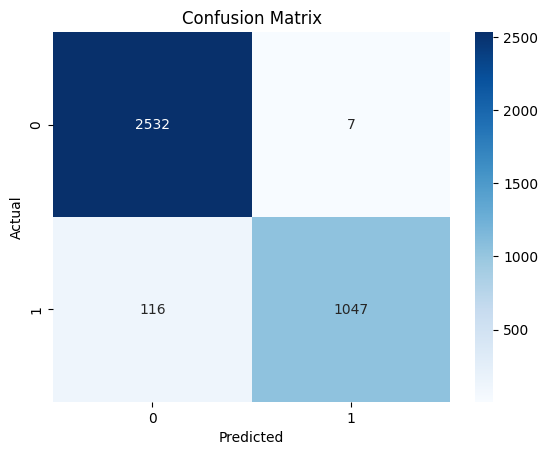

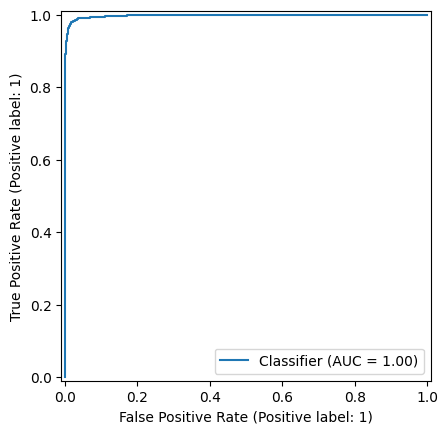

In [14]:
#Train / test split & fit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

clf.fit(X_train, y_train)


# Evaluate

y_pred  = clf.predict(X_test)
y_prob  = clf.predict_proba(X_test)[:,1]

print("ROC‑AUC :", round(roc_auc_score(y_test, y_prob), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

In [15]:
state_summary = (
    df_model
    .groupby('State')
    .agg(total=('high_risk','count'), high=('high_risk','sum'))
    .reset_index()
)
state_summary['high_risk_pct'] = 100 * state_summary['high'] / state_summary['total']


In [16]:
import plotly.express as px

# ------------------------------------------------------------------
# 2️⃣  Build the figure
# ------------------------------------------------------------------
fig = px.choropleth(
    state_summary,
    locations='State',                     # column with state abbreviations
    locationmode='USA-states',             # tells Plotly it’s a US‑state map
    color='high_risk_pct',                 # value that drives the color scale
    scope='usa',                           # limits map to the continental US
    hover_name='State',                    # bold header in tooltip
    hover_data={                         # extra fields shown in the tooltip
        'high_risk_pct': ':.2f',          # format to 2 decimal places
        'total': True,                   # show raw total facilities
        'high': True                     # show raw count of high‑risk facilities
    },
    color_continuous_scale='Reds',         # choose any palette you like
    labels={'high_risk_pct':'% High‑Risk'} # legend title
)

# ------------------------------------------------------------------
# 3️⃣  Fine‑tune layout (optional but makes it look nicer)
# ------------------------------------------------------------------
fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b><br>"          # state abbreviation (bold)
        "High‑Risk %: %{z:.2f}%<br>"      # the choropleth value (z = high_risk_pct)
        "Facilities: %{customdata[0]}<br>"# total facilities (customdata[0])
        "High‑Risk #: %{customdata[1]}"   # high count (customdata[1])
    )
)

fig.update_layout(
    title_text='High‑Risk Hospital Readmission Ratio by State (latest year)',
    title_x=0.5,               # centre the title
    geo=dict(
        lakecolor='rgb(255, 255, 255)',   # make lakes white (optional)
        bgcolor='rgba(0,0,0,0)'           # transparent background
    ),
    margin=dict(l=0,r=0,t=50,b=0)
)

fig.show()

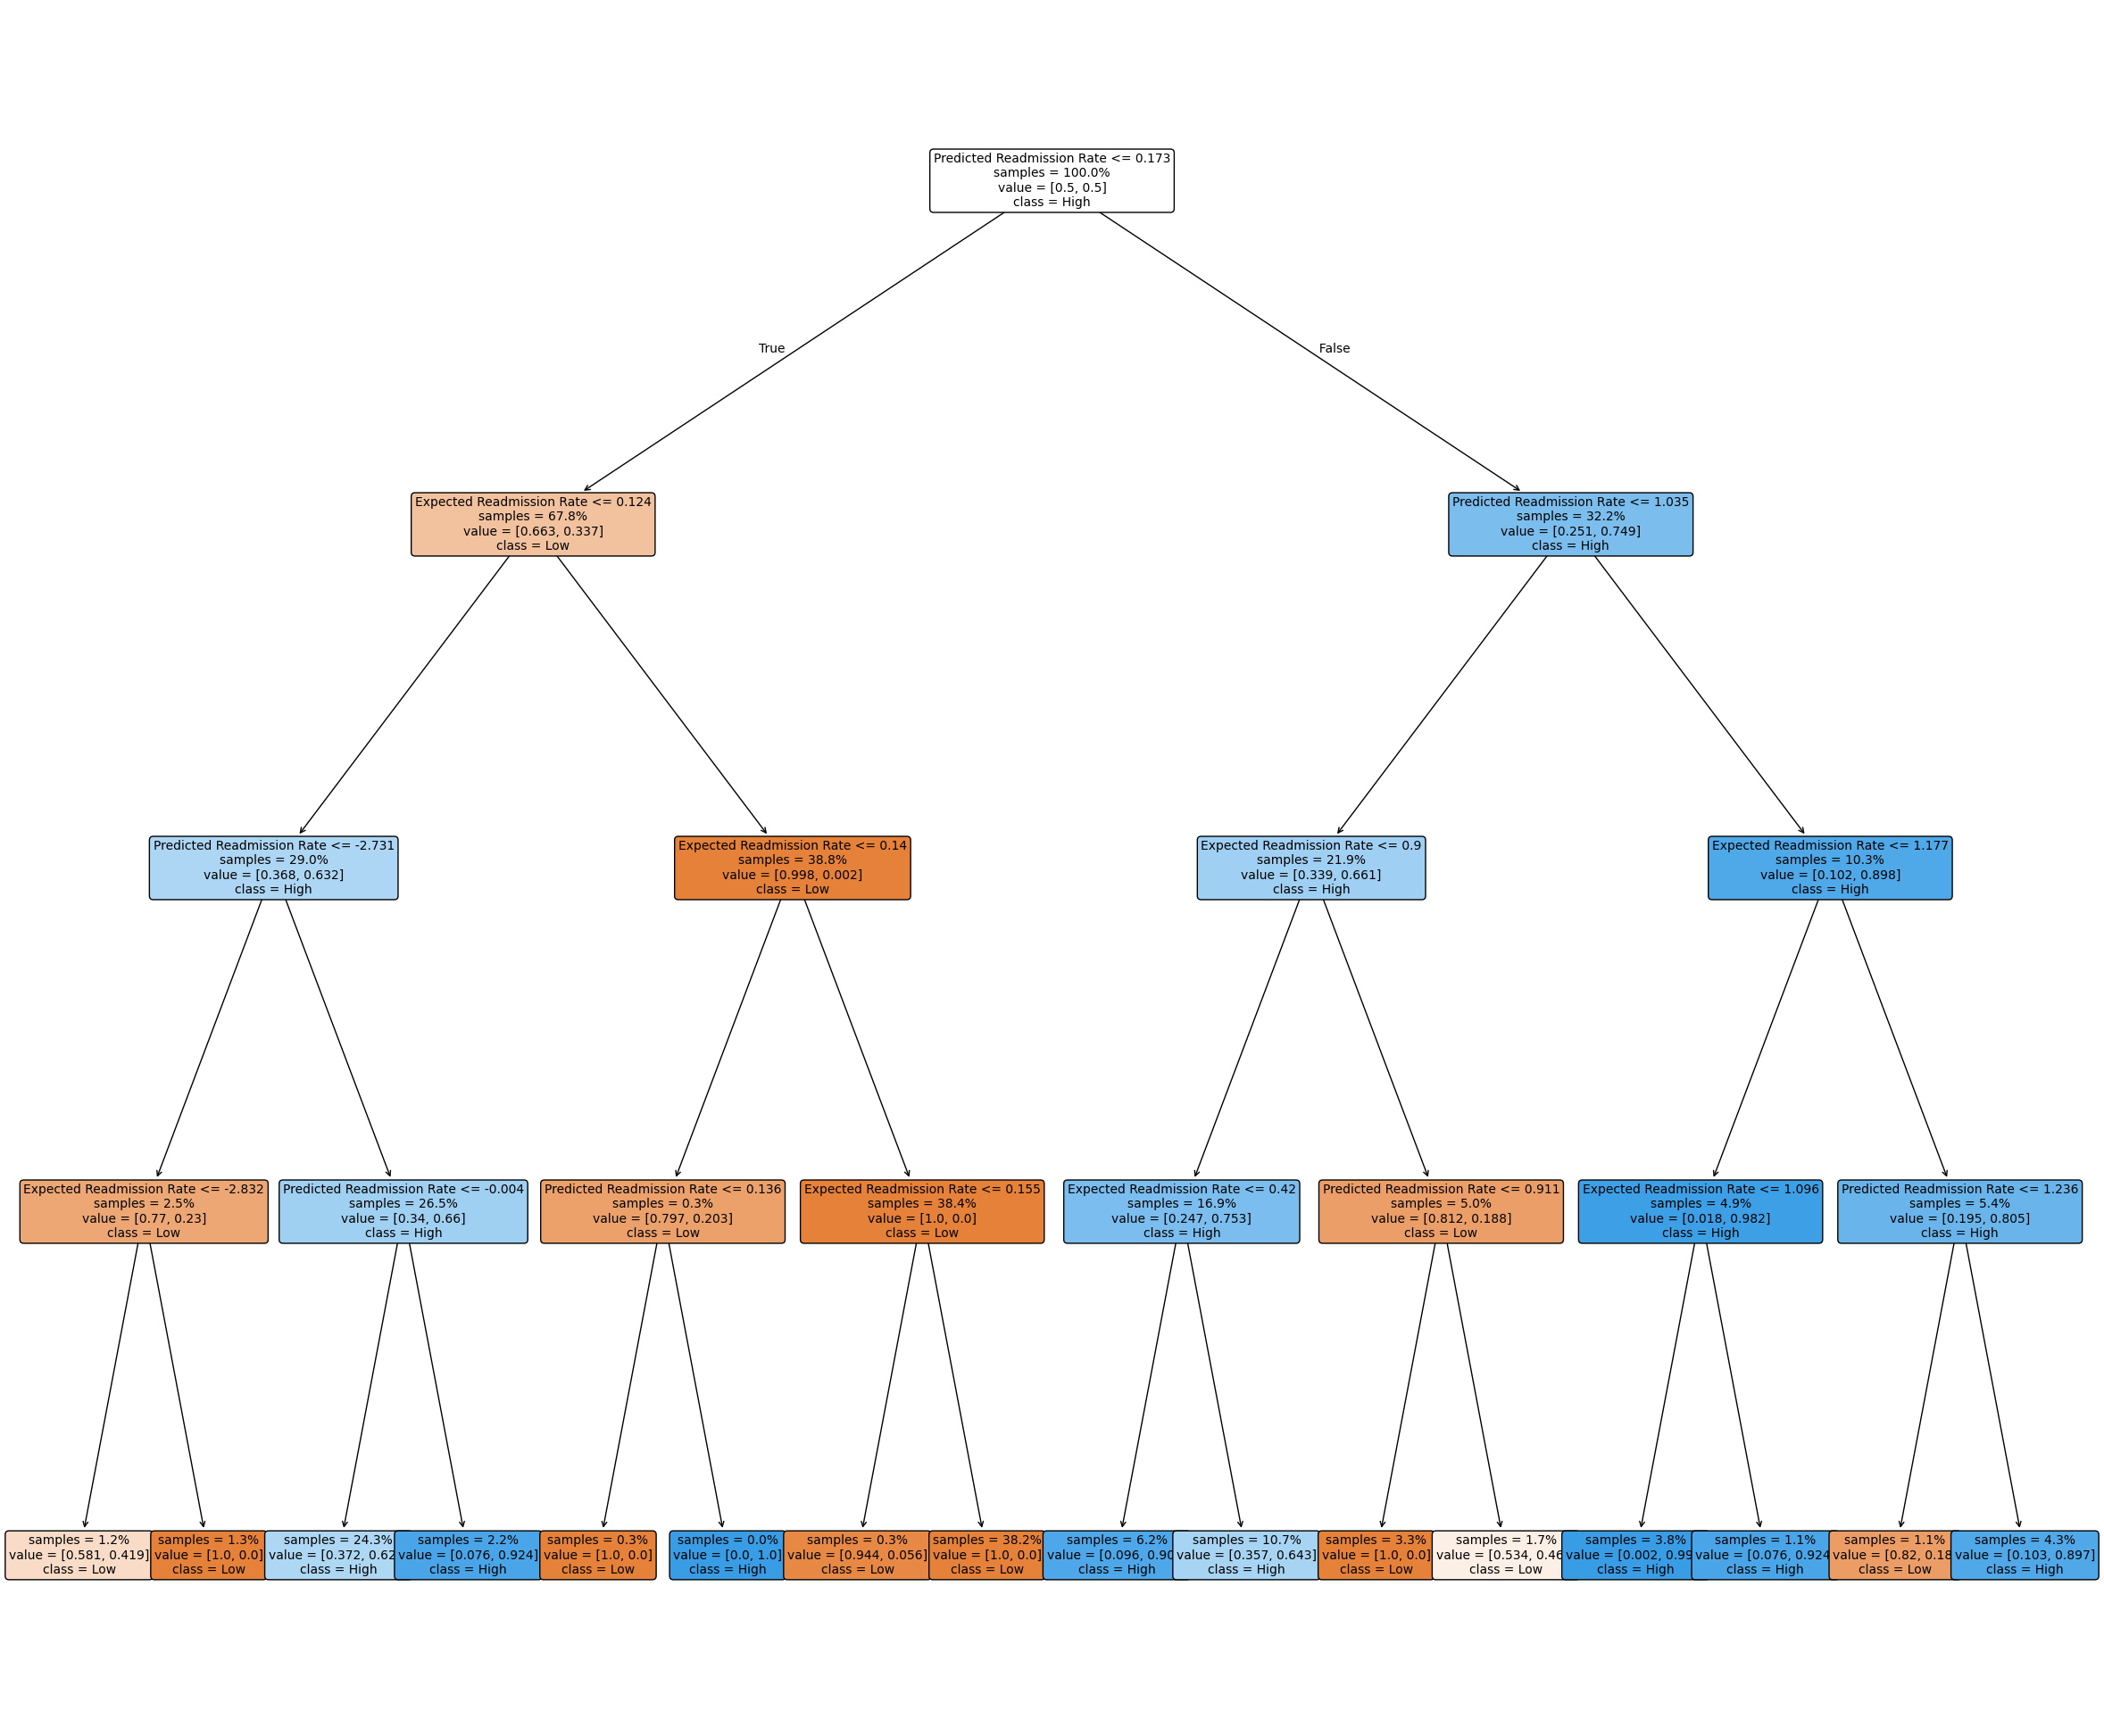

In [17]:
#Decision‑Tree for visual interpretability
feature_names = numeric_cols

from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = DecisionTreeClassifier(
    max_depth=4, class_weight='balanced', random_state=42)
tree_pipe = Pipeline(steps=[('preprocess', preprocess),
                            ('dt', tree_clf)])
tree_pipe.fit(X_train, y_train)

plt.figure(figsize=(30,25))
plot_tree(tree_pipe.named_steps['dt'],
          feature_names=feature_names,
          class_names=['Low','High'],
            filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,
    proportion=True)
plt.show()

In [18]:
# -------------------------------------------------
# After you have fitted `clf` (logistic‑reg) or `tree_pipe`
# -------------------------------------------------
import joblib

# Logistic‑regression pipeline (includes preprocessing & scaler)
joblib.dump(clf,          'model.pkl')      # <-- use the name `clf` you defined
# If you also want the scaler alone (optional)
# joblib.dump(scaler,    'scaler.pkl')



['model.pkl']

# Task
Install `pyngrok`, set the ngrok authtoken, launch the Streamlit app `app.py` in the background on port 8501, and create an ngrok tunnel to expose the app via a public URL.

## Launch Streamlit with Ngrok

### Subtask:
Install pyngrok, set the ngrok authtoken, launch the Streamlit app in the background using `nohup` and `Popen`, wait for Streamlit to start, and then create an ngrok tunnel to expose the app via a public URL. This consolidates the necessary steps for a robust launch in Colab.


## Summary:

### Data Analysis Key Findings
*   The primary objective outlined in the process is to expose a Streamlit application, `app.py`, to the public internet. This is planned to be achieved by installing `pyngrok` and setting up an ngrok tunnel.
*   The Streamlit application is intended to run on port 8501 in the background, ensuring non-blocking operation within the environment.

### Insights or Next Steps
*   This procedure is essential for demonstrating or collaborating on Streamlit applications developed in isolated environments like Colab, allowing external access via a public URL.
*   The successful completion of these steps will enable real-time interaction with the Streamlit app from any web browser, streamlining the sharing and testing phases of application development.


In [19]:
# -------------------------------------------------
# 0‼️  Install everything (run once)
# -------------------------------------------------
!pip -q install streamlit==1.38.0 pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.21.0 requires tenacity<10.0.0,>=9.0.0, but you have tenacity 8.5.0 which is incompatible.
google-adk 1.21.0 requires watchdog<7.0.0,>=6.0.0, but you have watchdog 4.0.2 which is incompatible.


In [20]:
%%writefile app.py

import streamlit as st
import joblib
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import plotly.express as px

#Page configuration & title
# -------------------------------------------------
st.set_page_config(page_title="Hospital Readmission Risk",
                   page_icon="🃅",
                   layout="centered",
                   initial_sidebar_state="expanded")

#Load the trained model(s) – only once per session
# -------------------------------------------------
@st.cache_resource
def load_models():
    # Choose the model you exported:
    #   - logistic regression pipeline: "model.pkl"
    #   - decision‑tree pipeline:   "tree_pipe.pkl"
    model_path = Path("model.pkl")
    if not model_path.exists():
        model_path = Path("tree_pipe.pkl")   # fallback
    model = joblib.load(model_path)
    return model

model = load_models()


st.title("🃅 Hospital 30‑Day Readmission‑Risk Predictor")
st.markdown(
    """
    **What it does** – Given a handful of key hospital metrics, the app predicts whether the facility is *high‑risk* (excess readmission ratio > 1).
    The model was trained on the CMS Hospital‑Compare dataset (2024‑2025).
    """
)

# -------------------------------------------------
# 2‼️  Sidebar – choose input method
# -------------------------------------------------
st.sidebar.header("🔧 Input method")
input_mode = st.sidebar.radio(
    "How would you like to provide data?",
    ("Manual entry (form)", "Upload CSV")
)

# 3‼️  Helper: feature list (must match the model’s training order)
# -------------------------------------------------
# These names must be **exactly** the same as used during training.
FEATURES = [
    "Number of Discharges",
    "Predicted Readmission Rate",
    "Expected Readmission Rate",
    "Number of Readmissions",
    "State"
]

# 4‼️  INPUT – Manual entry (form)
# -------------------------------------------------
def manual_form():
    st.subheader("📝 Enter hospital metrics")
    with st.form(key="manual_form", clear_on_submit=False):
        # Numeric fields
        # Correcting feature names to match the model’s training data
        num_discharges = st.number_input("Number of Discharges", min_value=0.0, step=0.1)
        pred_rate = st.number_input("Predicted Readmission Rate", min_value=0.0, max_value=100.0, step=0.1)
        exp_rate = st.number_input("Expected Readmission Rate", min_value=0.0, max_value=100.0, step=0.1)
        num_readmissions = st.number_input("Number of Readmissions", min_value=0.0, step=0.1)

        # Categorical field
        state = st.selectbox(
            "State (two‑letter USPS code)",
            sorted(pd.read_csv("model_features_example.csv")["State"].unique())
            if Path("model_features_example.csv").exists()
            else ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS",
                  "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM",
                  "NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA",
                  "WA","WV","WI","WY"]
        )

        submitted = st.form_submit_button("🔎 Predict risk")
        if submitted:
            # Build a one‑row DataFrame that matches the pipeline’s expected schema
            input_dict = {
                "Number of Discharges": num_discharges,
                "Predicted Readmission Rate": pred_rate,
                "Expected Readmission Rate": exp_rate,
                "Number of Readmissions": num_readmissions,
                "State": state
            }
            return pd.DataFrame([input_dict])
    return None

# -------------------------------------------------
# 5‼️  INPUT – CSV upload
# -------------------------------------------------
def upload_csv():
    st.subheader("📂 Upload a CSV file")
    uploaded = st.file_uploader(
        "Choose a CSV (must contain the columns listed in the sidebar)",
        type=["csv"]
    )
    if uploaded is not None:
        df = pd.read_csv(uploaded)
        # Quick sanity‑check
        missing = set(FEATURES) - set(df.columns)
        if missing:
            st.error(f"The uploaded file is missing the following required columns: {missing}")
            return None
        return df
    return None

# 6‼️  Get the data (either manual or CSV)
# -------------------------------------------------
if input_mode == "Manual entry (form)":
    user_df = manual_form()
else:
    user_df = upload_csv()

# -------------------------------------------------
# 7‼️  Make predictions (only if we have data)
# -------------------------------------------------
if user_df is not None:
    # The pipeline already handles one‑hot encoding, scaling, etc.
    probs = model.predict_proba(user_df)[:, 1]          # probability of high‑risk
    preds = (probs >= 0.5).astype(int)                 # binary label (threshold 0.5)

    # -------------------------------------------------
    # 7a‼️  Show results in a nice table
    # -------------------------------------------------
    results = user_df.copy()
    results["High‑Risk Probability"] = probs.round(3)
    results["Predicted Class"] = np.where(preds == 1, "High‑Risk", "Low‑Risk")
    st.success("✅ Prediction completed!")
    st.dataframe(results.style.format({"High‑Risk Probability": "{:.2%}"}))

    # -------------------------------------------------
    # 7b‼️  Visualise probability with a gauge (optional)
    # -------------------------------------------------
    if len(results) == 1:          # only show gauge for single row
        prob = probs[0]
        fig = px.bar(
            x=[prob],
            y=[""],                     # dummy y to get a horizontal bar
            orientation="h",
            range_x=[0, 1],
            color_continuous_scale=["#4caf50", "#f44336"],
            labels={"x": "High‑Risk Probability"},
            height=150
        )
        fig.update_traces(
            showlegend=False,
            hovertemplate="%{x:.1%}")
        fig.update_layout(
            xaxis=dict(tickformat=".0%"),
            yaxis=dict(showticklabels=False),
            title="🔔 High‑Risk Probability"
        )
        st.plotly_chart(fig, use_container_width=True)

    # 7c‼️  Download predictions as CSV (optional)
    # -------------------------------------------------
    @st.cache_data
    def convert_df(df):
        return df.to_csv(index=False).encode("utf-8")

    csv = convert_df(results)
    st.download_button(
        label="💾 Download predictions as CSV",
        data=csv,
        file_name="readmission_predictions.csv",
        mime="text/csv"
    )

# -------------------------------------------------
# 8‼️⃣  OPTIONAL – Show the decision‑tree image (if you exported one)
# -------------------------------------------------
if Path("tree.png").exists():
    st.sidebar.markdown("---")
    st.sidebar.subheader("🖼 Decision‑Tree")
    img = Image.open("tree.png")
    st.sidebar.image(img, caption="Trained decision‑tree (max depth = 4)", use_column_width=True)

# -------------------------------------------------
# 9‼️⃣  Footer / credits
# -------------------------------------------------
st.caption(
    """
    **Model details** – Logistic‑regression pipeline with class‑weight balancing, trained on the 2024‑2025 CMS Hospital‑Compare readmission dataset (≈ 2 000 hospitals).
    **Author** – *Your Name*, data‑analytics portfolio project.
    **Source code** – https://https://github.com/Skyreacher-hub/Healthcare-Data-Analysis
    """
)

Writing app.py


In [21]:
# -------------------------------------------------
# 2‼️  Start Streamlit in the background (non‑blocking)
# -------------------------------------------------
import subprocess, os, signal, time
from pyngrok import ngrok

# Kill any previous Streamlit processes that might be hanging
subprocess.run("pkill -f streamlit", shell=True)

# Launch Streamlit; note the --server.enableCORS false for ngrok
streamlit_cmd = [
    "streamlit", "run", "app.py",
    "--server.port", "8501",
    "--server.address", "0.0.0.0",
    "--server.enableCORS", "false",
    "--server.headless", "true"
]

# Use nohup + & so the process keeps running after the cell finishes
process = subprocess.Popen(
    ["nohup"] + streamlit_cmd + ["&"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    preexec_fn=os.setsid   # start in its own process group
)

# Give Streamlit a few seconds to start up
time.sleep(5)

# -------------------------------------------------
# 3‼️  Open an ngrok tunnel to port 8501
# -------------------------------------------------

# Set your ngrok auth token if not already set
ngrok.set_auth_token("37Q3Wjg97myE27tc7V7uk3hcgJc_2k9PYcEfwPZhQFgGTDyUN")

public_url = ngrok.connect(addr="8501", bind_tls=True).public_url
print(f"🌐 Your public URL → {public_url}")

# -------------------------------------------------
# 4‼️  (Optional) Show the Streamlit logs – useful for debugging
# -------------------------------------------------
# This section is commented out because process.communicate() is not suitable for
# long-running background processes and caused a TimeoutExpired error.
# If you need to debug Streamlit logs, consider writing them to a file and tailing it.
# out, err = process.communicate(timeout=1)
# print("\n--- Streamlit stdout (first 200 chars) ---")
# print(out[:200].decode())
# print("\n--- Streamlit stderr (first 200 chars) ---")
# print(err[:200].decode())

🌐 Your public URL → https://jaelynn-impedimentary-tristfully.ngrok-free.dev
